# Digit Recognizer

Using sklearn's **digits** dataset to perform classification.

The digits dataset contains handwritten digits where each label represents the written number.

The model used to perform the classification will be a Convolutional model with a fully connected layer.

The model will be built from scratch, without transfer learning.

### Imports

In [0]:
import random
from tqdm.notebook import tqdm

from matplotlib.colors import TABLEAU_COLORS
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

from sklearn import datasets as ds
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report as class_report
from sklearn.metrics import confusion_matrix

import torch
from torch import nn
from torch import functional as F
from torchvision import transforms as T

### Data visualization

We'll load the data given by sklearn, and plot some random digits to understand the *X* -> *y* relation.

In [2]:
digits = ds.load_digits()

X, y = digits.images, digits.target

X.shape, y.shape

((1797, 8, 8), (1797,))

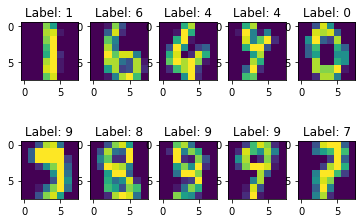

In [3]:
fig, ax = plt.subplots(2, 5)
ax = ax.ravel()

for i in range(10):
  idx = random.randint(0, len(X)-1)

  ax[i].set_title(f'Label: {y[idx]}')
  ax[i].imshow(X[idx])

Let's see the distribution per class:

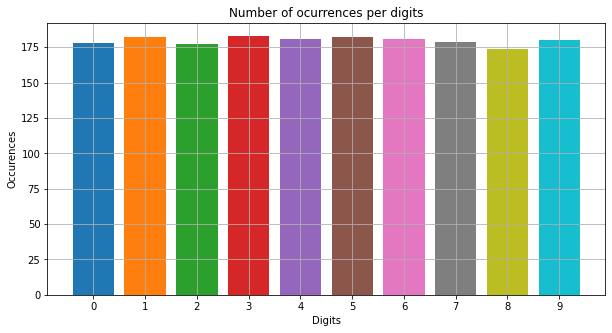

In [4]:
classes = np.unique(digits.target)
distribution = np.array([np.count_nonzero(digits.target == c) for c in classes])

fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title('Number of ocurrences per digits')
ax.bar(classes, distribution, color=TABLEAU_COLORS)
ax.set_xticks(classes)
ax.grid()
plt.xlabel('Digits')
plt.ylabel('Occurences')
plt.show()

### Create Dataset

Create a pytorch Dataset, transforming the array to a Pytorch tensor.

Split the dataset into train & validation, and finally setup a dataloader.

But first, let's setup some constants:

In [0]:
num_classes = len(np.unique(y))
input_shape = X[0].shape
batch_size = 64
mean, std = [0.5], [0.5]

In [0]:

def to_tensor(im):
  transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean, std)
  ])
  tensor = transform(im)
  return tensor

In [0]:
class DigitsDataset(torch.utils.data.Dataset):
  def __init__(self, X, y, num_classes):
    self.X = X
    self.y = y
    self.num_classes = num_classes
  
  def __len__(self):
    return len(self.X)
  
  def __getitem__(self, idx):
    im = self.X[idx]
    label = self.y[idx]
    return to_tensor(im), label

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=46)

train_dataset = DigitsDataset(X_train, y_train, num_classes)
val_dataset =  DigitsDataset(X_val, y_val, num_classes)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

In [9]:
len(train_loader.dataset), len(val_loader.dataset)

(1203, 594)

Let's check our split didn't affect the digits distribution.

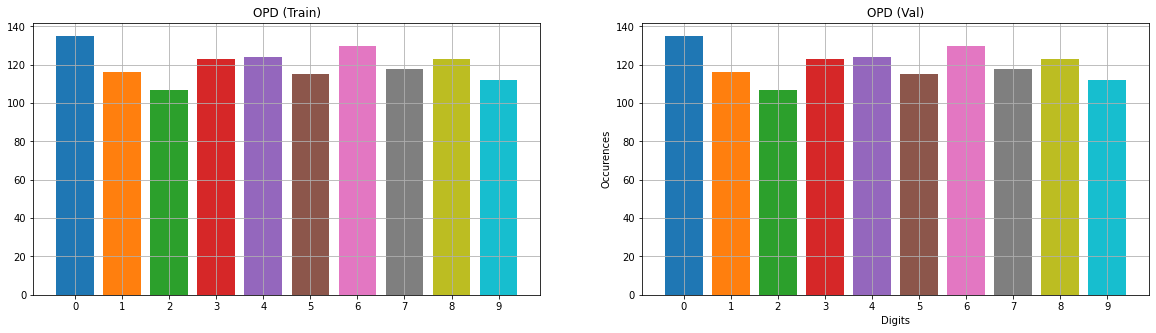

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

# get train and val occurences per digit

train_classes = np.unique(y_train)
train_dist = np.array([np.count_nonzero(y_train == c) for c in train_classes])

val_classes = np.unique(y_val)
val_dist = np.array([np.count_nonzero(y_val == c) for c in val_classes])

# plot train occurences per digit

ax[0].set_title('OPD (Train)')
ax[0].bar(train_classes, train_dist, color=TABLEAU_COLORS)
ax[0].set_xticks(classes)
ax[0].grid()

plt.xlabel('Digits')
plt.ylabel('Occurences')

# plot val occurences per digit

ax[1].set_title('OPD (Val)')
ax[1].bar(train_classes, train_dist, color=TABLEAU_COLORS)
ax[1].set_xticks(classes)
ax[1].grid()

plt.xlabel('Digits')
plt.ylabel('Occurences')

plt.show()

### Model building

Our model will have two sections:

- Convolutional Layers
- Linear layers

In [0]:
class Net(nn.Module):

  def __init__(self, num_classes):
    super(Net, self).__init__()

    # convolutions
    self.cnn_layers = nn.Sequential(
      nn.Conv2d(1, 32, kernel_size=2),
      nn.MaxPool2d(kernel_size=2),
      nn.ReLU(inplace=True),

      nn.Conv2d(32, 64, kernel_size=3),
      nn.Dropout2d(0.2),
      nn.ReLU(inplace=True),
    )

    # fully connected
    self.linear = nn.Sequential(
      nn.Flatten(),
      nn.Linear(64, 64),
      nn.ReLU(inplace=True),
      nn.Dropout(),
      nn.Linear(64, 128),
      nn.ReLU(inplace=True),
      nn.Linear(128, num_classes),
      nn.Softmax(dim=1)
    )

  def forward(self, x):
    x = self.cnn_layers(x)
    x = self.linear(x)
    return x

net = Net(num_classes=num_classes)

### Training params

We need to define the loss, metrics and optimizers we'll be using during the training.

As we have a multi-class problem, we need to use a Categorical Crossentropy Loss. We'll use the accuracy metric and Adam as optimizer.

In [0]:
learning_rate = 0.001
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

### Training algorithm

First we'll write functions to define the behavior per training and validation epoch.

In [0]:
def get_loss_acc(x, y, model, criterion, device):
    # forward the input through the net
    out = model(x)

    # get loss & accuracy
    loss = criterion(out, y)
    with torch.no_grad():
      idx = torch.argmax(out, axis=-1) == y
      acc = torch.sum(idx)
    
    return loss, acc


def train_epoch(model, data_loader, criterion, optimizer, device):
  model.train()
  model.to(device)

  # init step loss & accuracty
  epoch_loss, epoch_acc = 0., 0.

  for x, y in data_loader:
    x, y = x.to(device).float(), y.to(device)

    loss, acc = get_loss_acc(x, y, model, criterion, device)
    
    # optimize model
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # save loss & acc
    epoch_loss += loss.item() * y.size(0)
    epoch_acc += acc
  
  epoch_loss /= len(data_loader.dataset)
  epoch_acc /= len(data_loader.dataset)

  return epoch_loss, epoch_acc


def validate_epoch(model, data_loader, criterion, device):
  model.eval()
  model.to(device)

  epoch_loss, epoch_acc = 0., 0.

  with torch.no_grad():
    for x, y in data_loader:
      x, y = x.to(device).float(), y.to(device)

      loss, acc = get_loss_acc(x, y, model, criterion, device)

      # save loss & acc
      epoch_loss += loss.item() * y.size(0)
      epoch_acc += acc
  
  # get final loss & acc
  epoch_loss /= len(data_loader.dataset)
  epoch_acc /= len(data_loader.dataset)

  return epoch_loss, epoch_acc

### Train!

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 50

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for e in tqdm(range(epochs)):
  train_loss, train_acc = train_epoch(net, train_loader, criterion, optimizer, device)
  val_loss, val_acc = validate_epoch(net, val_loader, criterion, device)

  train_losses.append(train_loss)
  train_accuracies.append(train_acc)
  val_losses.append(val_loss)
  val_accuracies.append(val_acc)


print(f'Final => train_loss {train_losses[-1]:.3f} train_acc {train_accuracies[-1]:.3f} val_loss {val_losses[-1]:.3f} val_acc {val_accuracies[-1]:.3f}')


Final => train_loss 1.487 train_acc 0.978 val_loss 1.492 val_acc 0.968


### Let's check the training history

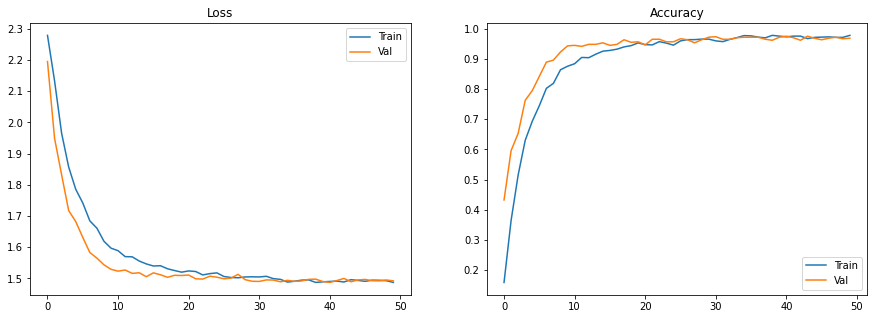

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].set_title('Loss')
ax[0].plot(train_losses, label='Train')
ax[0].plot(val_losses, label='Val')
ax[0].legend()

ax[1].set_title('Accuracy')
ax[1].plot(train_accuracies, label='Train')
ax[1].plot(val_accuracies, label='Val')
ax[1].legend()

plt.show()

### Test

Now that our model has trained, we need to understand what level of performance we have achieved.

In order to do this, we'll predict our test set and get some metrics from it.

In [16]:
net.eval()

# create the test set

X_test = torch.from_numpy(X_val).to(device).reshape(len(X_val), 1, 8, 8).float()
y_test = torch.from_numpy(y_val).to(device)

# predict the test set

y_pred = net(X_test)
y_pred = torch.argmax(y_pred, axis=-1)
y_pred.shape

torch.Size([594])

In [0]:
# convert to numpy

y_pred = y_pred.detach().cpu().numpy()
y_true = y_test.detach().cpu().numpy()
X_test = X_test.detach().cpu().numpy()

# create labels and target names
labels = range(num_classes)
names = [f'Digit {c}' for c in range(num_classes)]

### Classification report

In [18]:
# get classification report

report = class_report(y_true,
                      y_pred,
                      labels=labels,
                      target_names=names,
                      zero_division=False)

print(report)

              precision    recall  f1-score   support

     Digit 0       1.00      1.00      1.00        43
     Digit 1       0.96      0.97      0.96        66
     Digit 2       1.00      0.97      0.99        70
     Digit 3       1.00      0.95      0.97        60
     Digit 4       1.00      0.96      0.98        57
     Digit 5       0.97      0.96      0.96        67
     Digit 6       0.94      1.00      0.97        51
     Digit 7       0.97      1.00      0.98        61
     Digit 8       0.92      0.92      0.92        51
     Digit 9       0.91      0.94      0.93        68

    accuracy                           0.97       594
   macro avg       0.97      0.97      0.97       594
weighted avg       0.97      0.97      0.97       594



### Confusion matrix

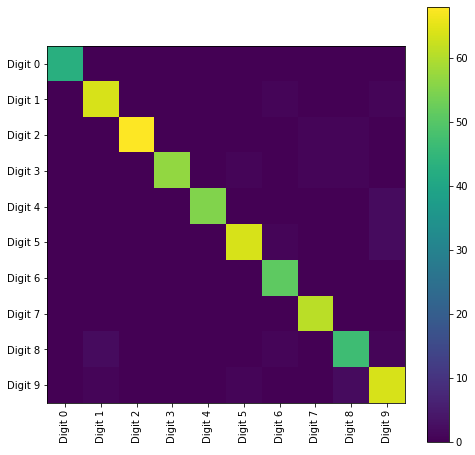

In [19]:
fig, ax = plt.subplots(figsize=(8, 8))
cnf_matrix = confusion_matrix(y_true, y_pred, labels=labels)
im = ax.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar(im)
tick_marks = np.arange(num_classes)
_ = plt.xticks(tick_marks, names, rotation=90)
_ = plt.yticks(tick_marks, names)